In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter

def process_q2(text):
    if pd.isnull(text):
        return None
    numbers = re.findall(r'\b\d+(?:\.\d+)?\b', text)
    numbers = [float(num) for num in numbers]
    filtered_numbers = [num for num in numbers if 1 <= num <= 10]
    if filtered_numbers:
        result = sum(filtered_numbers) / len(filtered_numbers)
    elif ',' in text:
        return text.count(',') + 1
    else:
        result = len(text) / 5
    return np.ceil(result)

def extract_numeric(value):
    if isinstance(value, str):
        value = value.lower().strip()
        numbers = re.findall(r'\d+', value)
        if numbers:
            return int(numbers[0])
        return "unknown"
    return value



def clean_drink(value):
    drink_map = {
        "coke": ["coke", "cola", "diet coke", "pepsi", "diet pepsi", "soda", "pop", "soft", "fanta", "sprite", "ginger"],
        "juice": ["juice", "nestea", "lemonade"],
        "tea": ["tea", "matcha"],
        "milk": ["ayran", "milk", "dairy"],
        "beer": ["beer", "wine", "alcoholic", "sake", "soju"],
        "water": ["water"],
        "soup": ["miso", "soup"]
    }
    if isinstance(value, str):
        value = re.sub(r'[^a-z0-9 ]', '', value.lower().strip())
        for category, keywords in drink_map.items():
            if any(keyword in value for keyword in keywords):
                return category
    return "unknown"

def one_hot_encode(df, column_name, categories):
    if column_name in df.columns:
        df[column_name] = df[column_name].str.lower().str.strip()
        df[column_name] = df[column_name].apply(lambda x: x.split(",") if isinstance(x, str) else [])
        for category in categories:
            df[f"{column_name}_{category}"] = df[column_name].apply(lambda x: 1 if category in x else 0)
        df.drop(columns=[column_name], inplace=True)
    return df

def clean_and_process_csv(file_path):
    df = pd.read_csv(file_path, dtype=str)
    df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
    df = df.drop_duplicates().fillna("unknown")

    df.rename(columns={
    'q1:_from_a_scale_1_to_5,_how_complex_is_it_to_make_this_food?_(where_1_is_the_most_simple,_and_5_is_the_most_complex)': 'q1',
    'q7:_when_you_think_about_this_food_item,_who_does_it_remind_you_of?':'q7',
    "q3:_in_what_setting_would_you_expect_this_food_to_be_served?_please_check_all_that_apply":'q3'
    }, inplace=True)

    q2_col = "q2:_how_many_ingredients_would_you_expect_this_food_item_to_contain?"
    if q2_col in df.columns:
        df['q2'] = df[q2_col].apply(process_q2)
        df.drop(columns=[q2_col], inplace=True)

    q4_col = "q4:_how_much_would_you_expect_to_pay_for_one_serving_of_this_food_item?"
    if q4_col in df.columns:
        df['q4'] = df[q4_col].apply(extract_numeric)
        df.drop(columns=[q4_col], inplace=True)

    q6_col = "q6:_what_drink_would_you_pair_with_this_food_item?"
    if q6_col in df.columns:
        df['q6'] = df[q6_col].apply(clean_drink)
        for cat in ["coke", "juice", "tea", "milk", "beer", "water", "soup"]:
            df[f'drink_{cat}'] = df['q6'].apply(lambda x: 1 if x == cat else 0)
        df.drop(columns=[q6_col, "q6"], inplace=True)

    q8_col = "q8:_how_much_hot_sauce_would_you_add_to_this_food_item?"

    def map_hot_sauce_response(text):
        text = text.lower().strip()
        if text == "unknown":
            return "none"
        elif text == "a little (mild)":
            return "mild"
        elif text == "a moderate amount (medium)":
            return "medium"
        elif text == "a lot (hot)":
            return "hot"
        elif text == "i will have some of this food item with my hot sauce":
            return "with_hot_sauce"
        else:
            return "unknown"

    print(df[q8_col].unique()[:10])


    if q8_col in df.columns:
        df[q8_col] = df[q8_col].astype(str).apply(map_hot_sauce_response)
        for category in ["none", "mild", "medium", "hot", "with_hot_sauce"]:
            df[f'hot_sauce_{category}'] = df[q8_col].apply(lambda x: 1 if x == category else 0)
        df.drop(columns=[q8_col], inplace=True)

    df = one_hot_encode(df, "q7",
                        ["parents", "siblings", "friends", "teachers", "strangers"])
    df = one_hot_encode(df, "q3",
                        ["week day lunch", "week day dinner", "weekend lunch", "weekend dinner", "at a party", "late night snack"])

    text_column = "q5:_what_movie_do_you_think_of_when_thinking_of_this_food_item?"
    word_counts = Counter()

    stop_words = set("i me my myself we our ours you your they them their what which who this that these those am is are was were be been being have has had do does did doing a an the and but if or because as until while of at by for with about between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most some such no nor not only own same so than too very s t can will just don should now d ll m o re ve y".split())

    def clean_special_symbols(text):
        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    if text_column in df.columns:
        df[text_column] = df[text_column].apply(clean_special_symbols)
        df[text_column] = df[text_column].apply(
            lambda text: [word for word in text.strip().split() if word not in stop_words]
        )
        for words in df[text_column]:
            word_counts.update(words)

        unique_words = sorted(word_counts.keys())
        bow_df = pd.DataFrame(0, index=df.index, columns=unique_words)
        for idx, words in enumerate(df[text_column]):
            for word in words:
                bow_df.at[idx, word] = 1
        df.drop(columns=[text_column], inplace=True)
        df = pd.concat([df, bow_df], axis=1)

    for column in df.columns:
        if column != "label":
            df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0)
    print(df.columns)
    df.drop(columns=['id'], errors='ignore', inplace=True)


    output_path = "cleaned_" + file_path
    df.to_csv(output_path, index=False)
    print(f"Cleaned dataset saved to {output_path}")
    return output_path

clean_and_process_csv("cleaned_data_combined_modified.csv")

['A little (mild)' 'unknown' 'A moderate amount (medium)'
 'I will have some of this food item with my hot sauce' 'A lot (hot)']
Index(['id', 'q1', 'label', 'q2', 'q4', 'drink_coke', 'drink_juice',
       'drink_tea', 'drink_milk', 'drink_beer',
       ...
       'yakuza', 'year', 'yeh', 'york', 'young', 'youre', 'za', 'zodiac',
       'zohan', 'zootopia'],
      dtype='object', length=921)
Cleaned dataset saved to cleaned_cleaned_data_combined_modified.csv


'cleaned_cleaned_data_combined_modified.csv'

Descriptive Statistics for Numerical Features:
                q1           q2           q4
count  1644.000000  1644.000000  1644.000000
mean      3.174574     5.557178    10.900852
std       1.021050     2.618770     6.807001
min       1.000000     1.000000     0.000000
25%       2.000000     4.000000     6.000000
50%       3.000000     5.000000    10.000000
75%       4.000000     7.000000    15.000000
max       5.000000    29.000000   100.000000


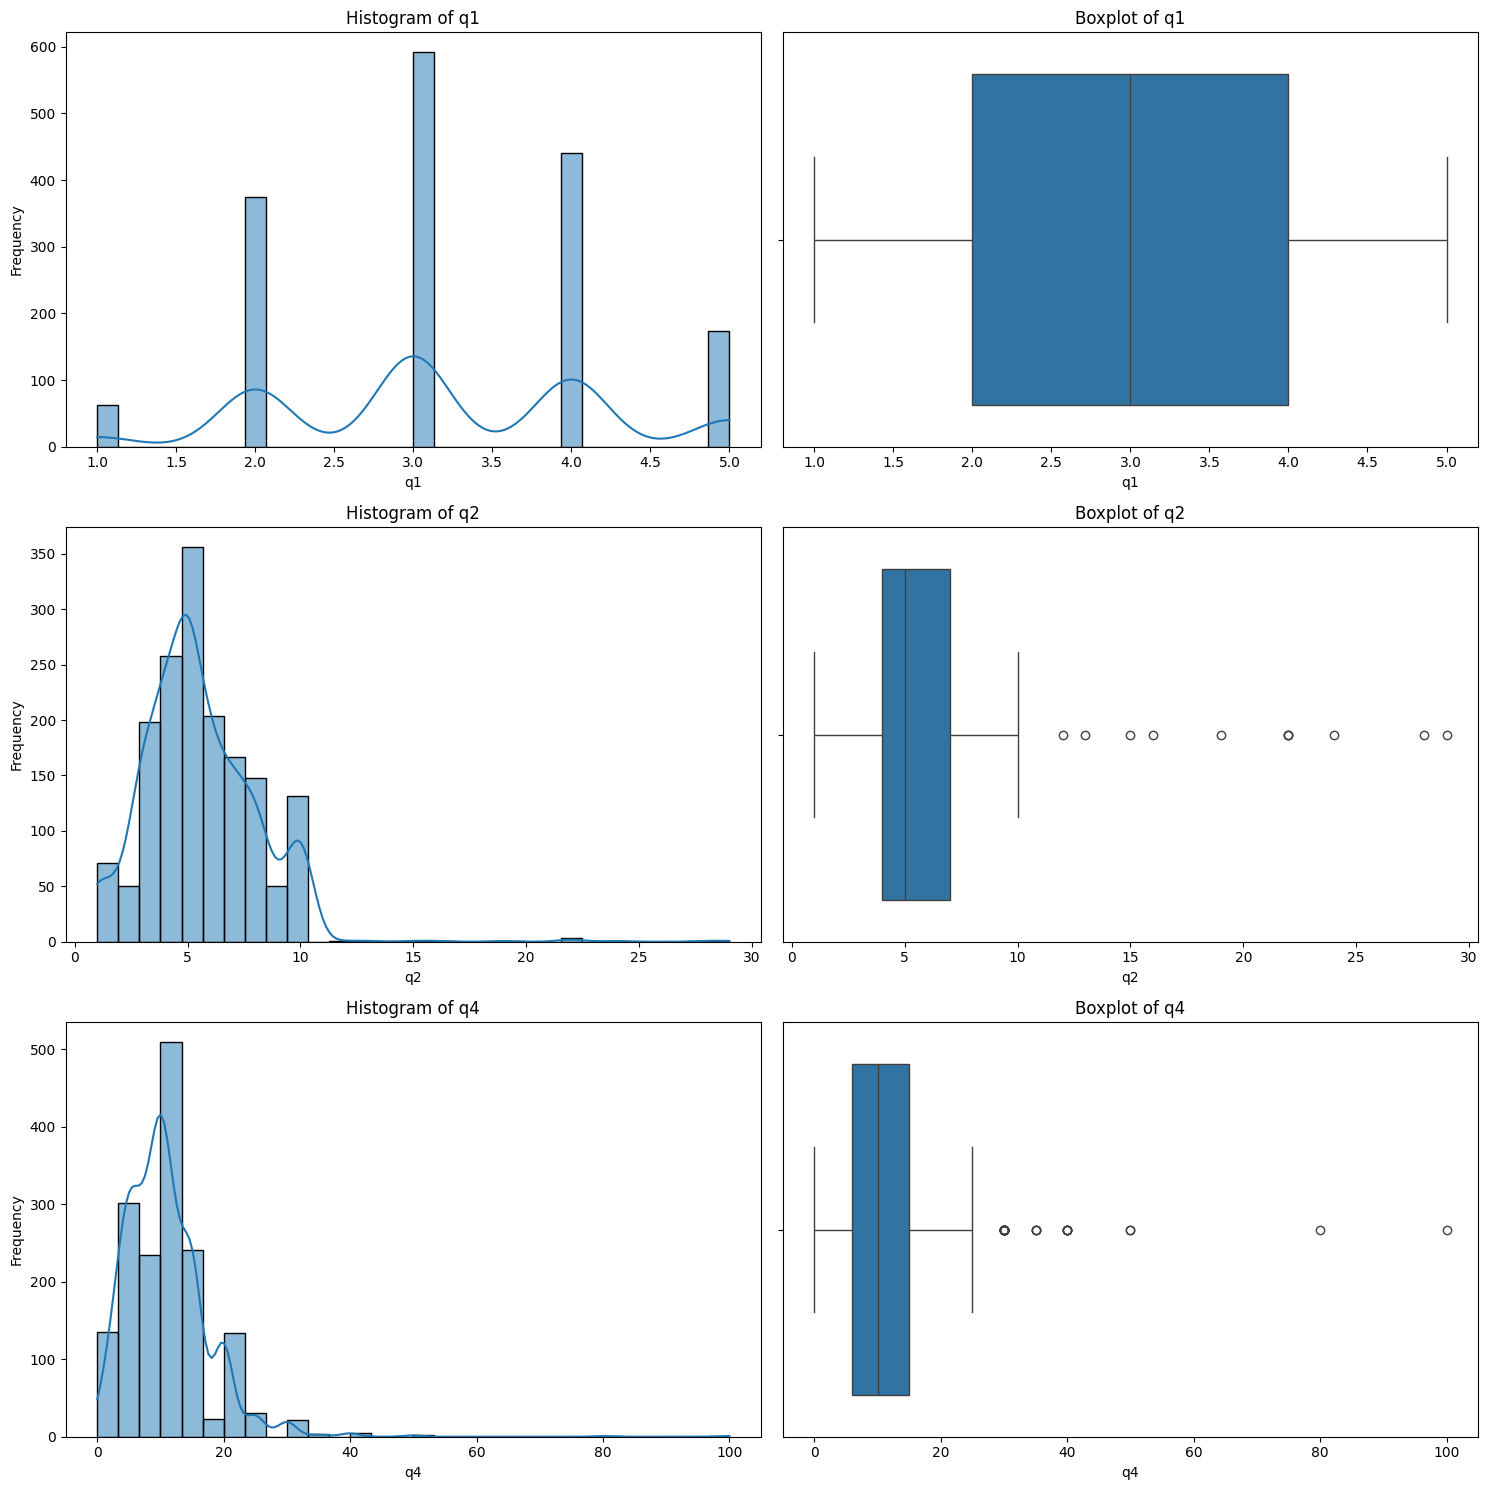

Categorical features (non-movie) to be plotted:
['drink_coke', 'drink_juice', 'drink_tea', 'drink_milk', 'drink_beer', 'drink_water', 'drink_soup', 'hot_sauce_none', 'hot_sauce_mild', 'hot_sauce_medium', 'hot_sauce_hot', 'hot_sauce_with_hot_sauce', 'q7_parents', 'q7_siblings', 'q7_friends', 'q7_teachers', 'q7_strangers', 'q3_week day lunch', 'q3_week day dinner', 'q3_weekend lunch', 'q3_weekend dinner', 'q3_at a party', 'q3_late night snack']


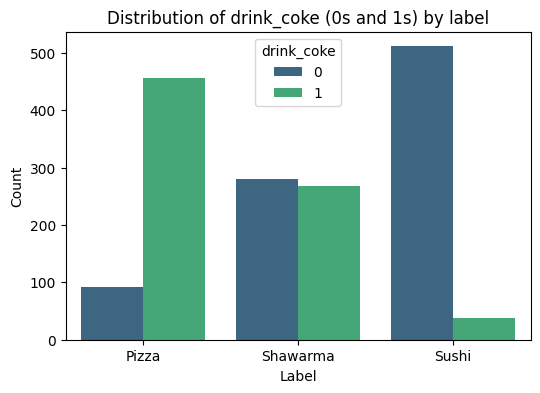

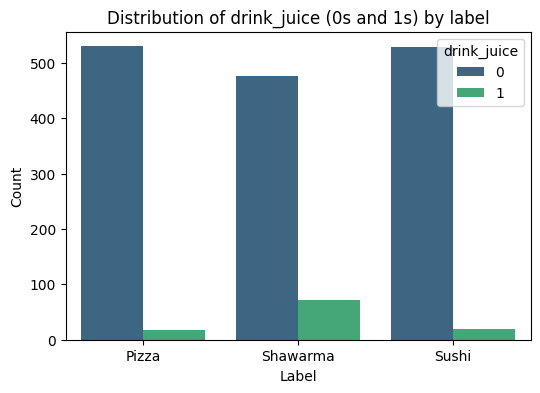

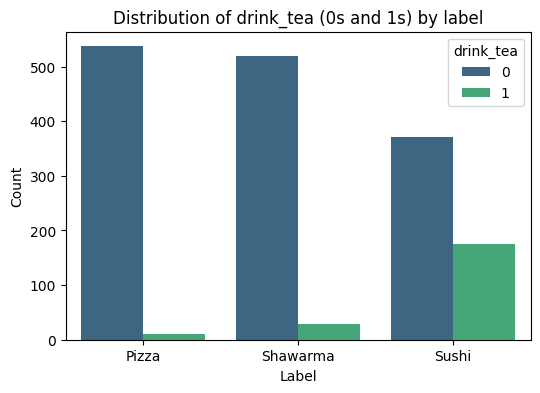

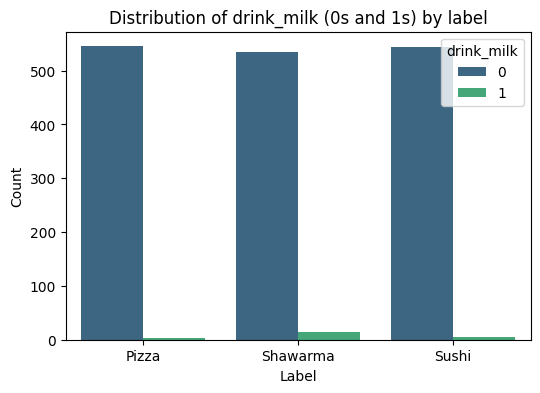

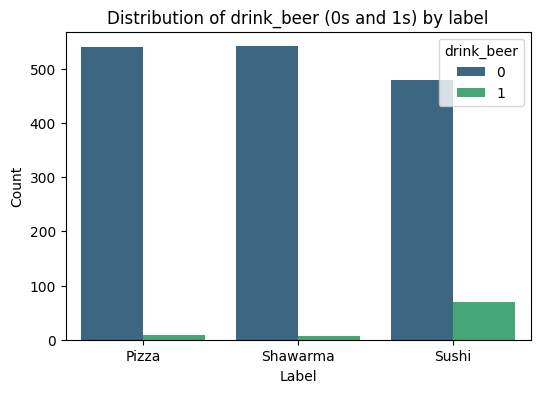

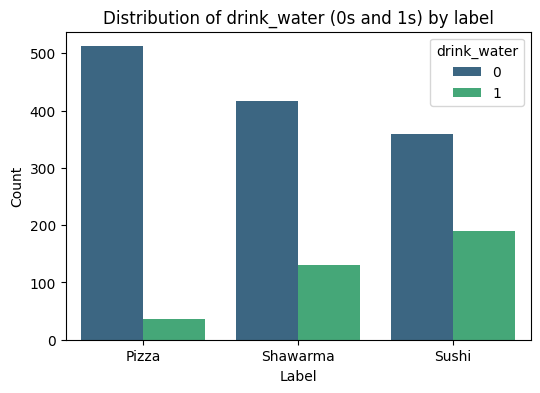

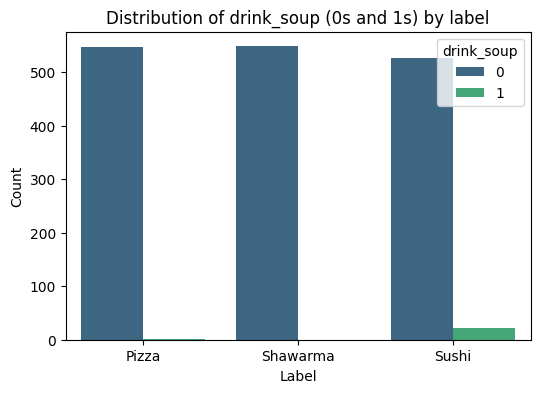

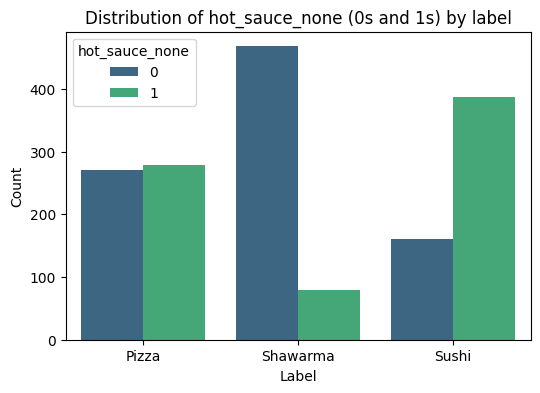

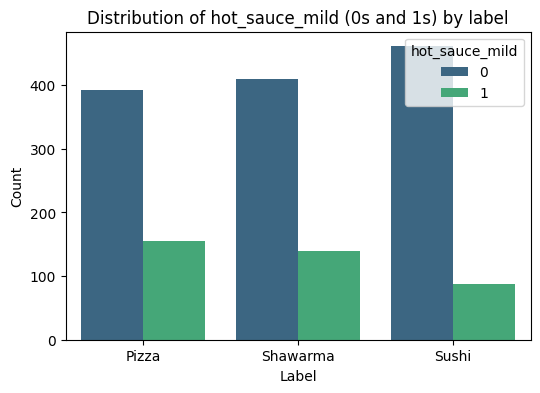

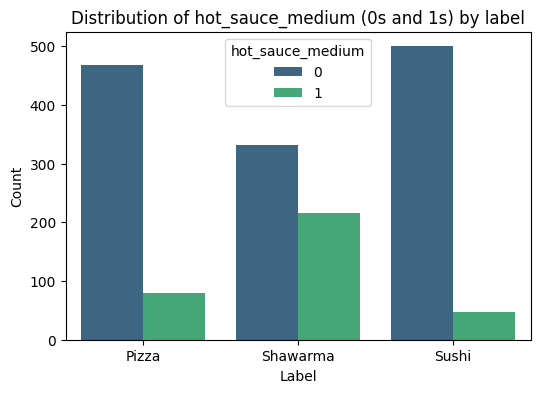

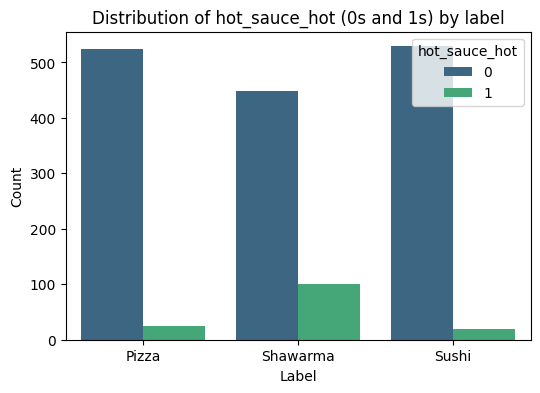

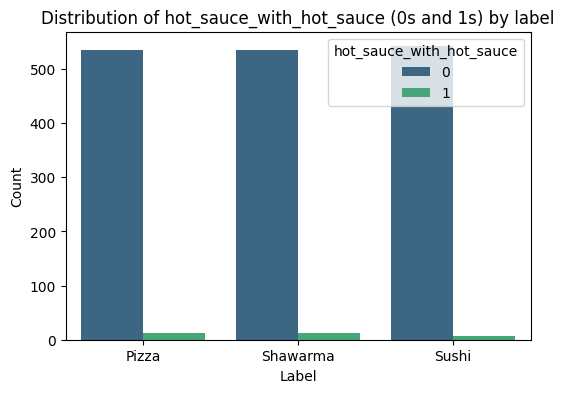

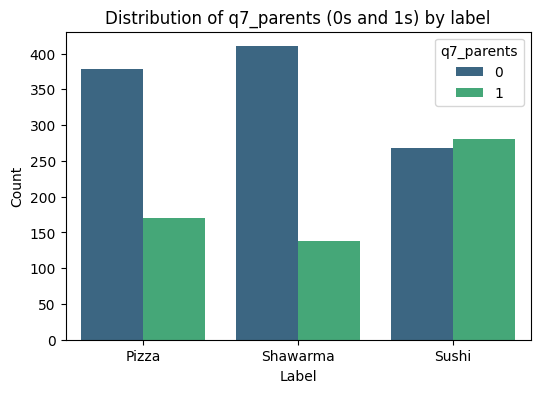

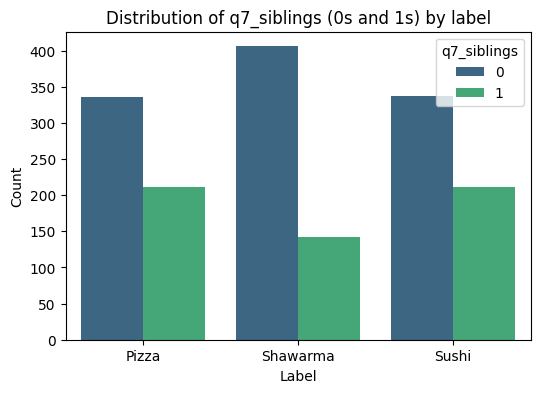

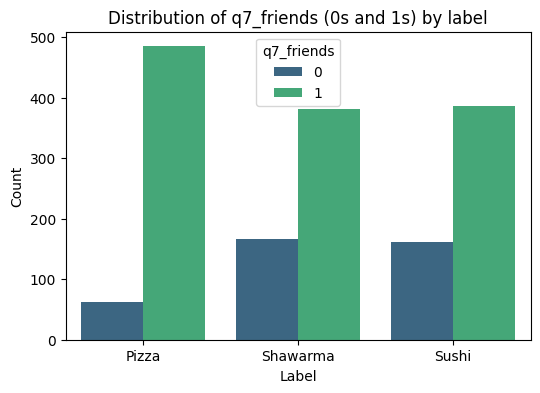

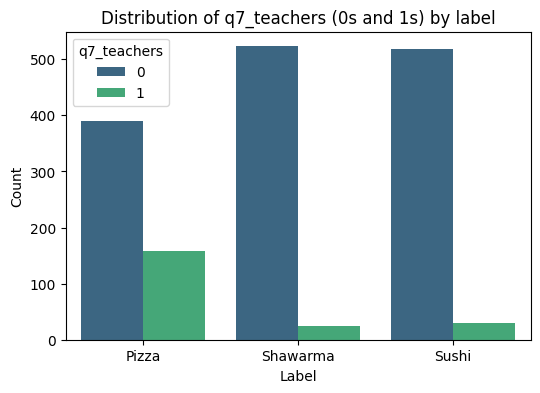

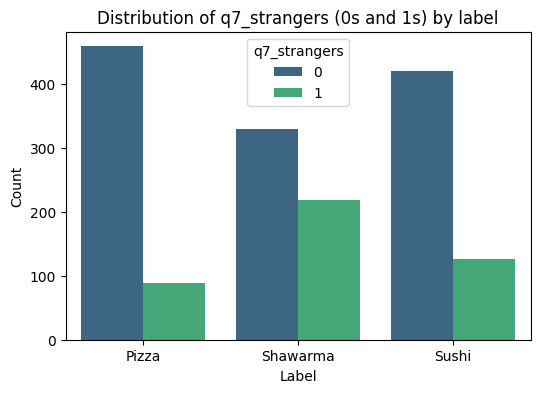

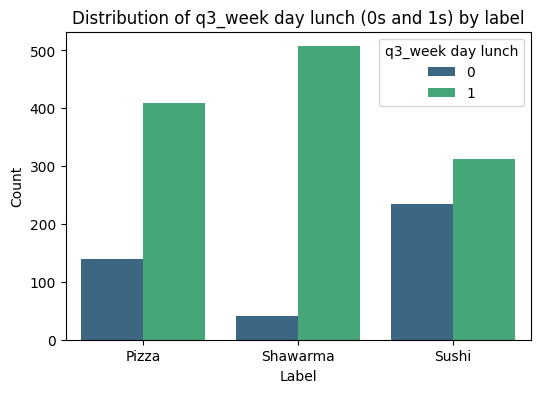

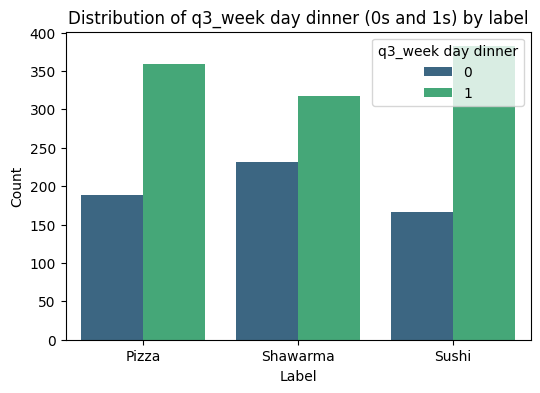

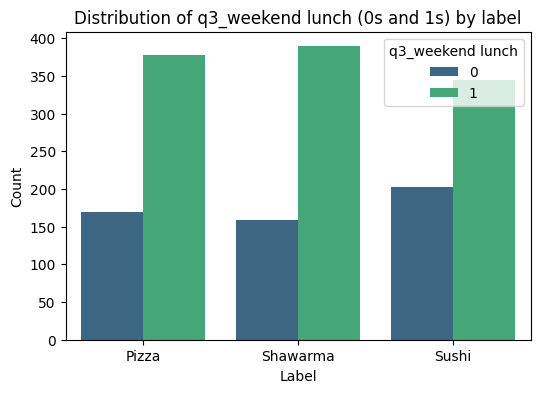

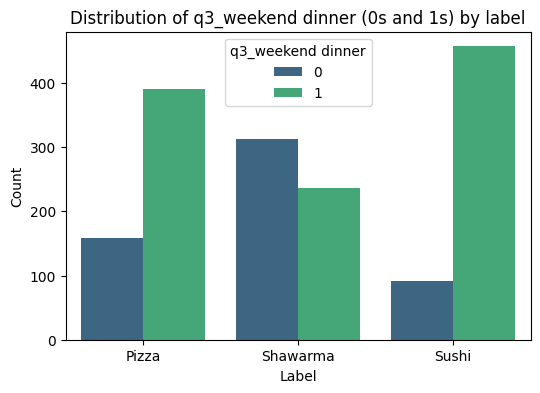

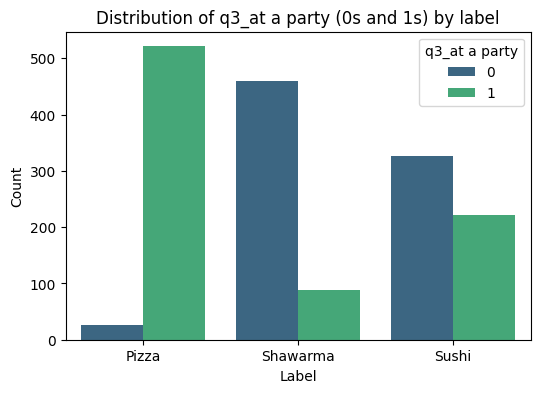

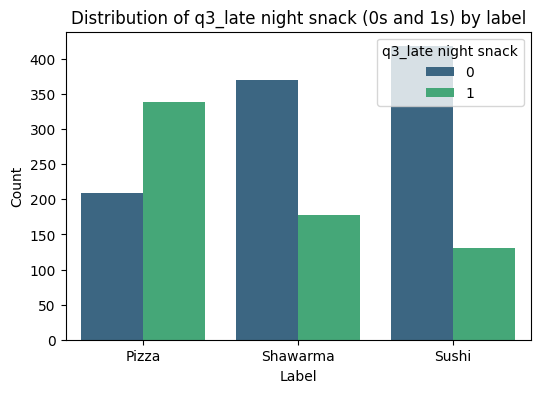

<ipython-input-2-27ec79c66255>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top20_movie_features.index, y=top20_movie_features.values, palette="magma")


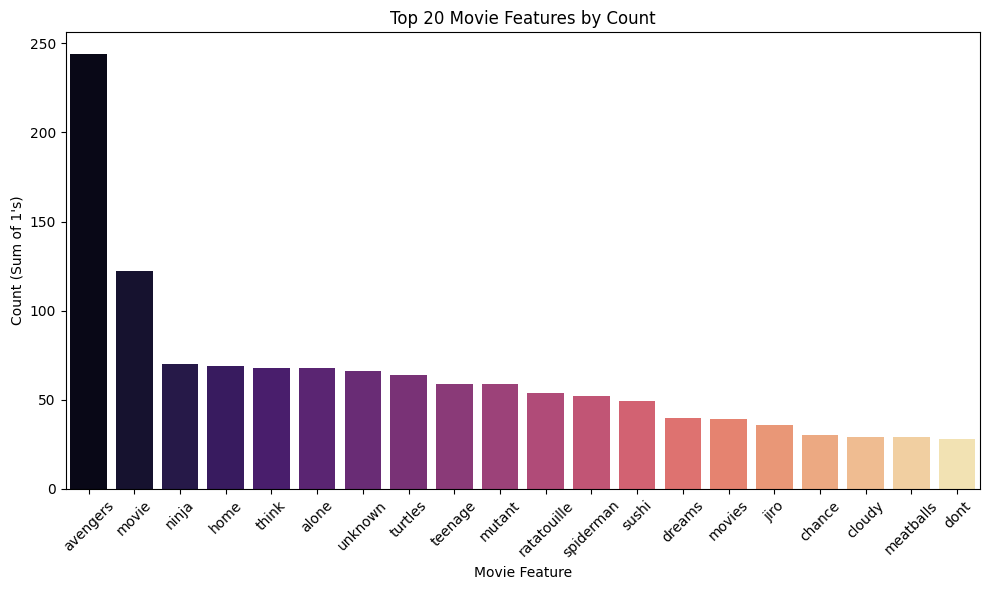


Top 20 Features with Highest F-Scores:
                 Feature     F-Score        p-value
24         q3_at a party  631.084759  5.126139e-204
3             drink_coke  531.841669  8.811777e-179
73              avengers  364.017078  1.448174e-131
10        hot_sauce_none  228.989277   1.945475e-88
5              drink_tea  155.556092   1.372225e-62
23     q3_weekend dinner  119.159693   4.776431e-49
18           q7_teachers  104.669077   1.648389e-43
25   q3_late night snack  102.937388   7.667662e-43
20     q3_week day lunch  102.125866   1.577442e-42
2                     q4  100.549536   6.416341e-42
12      hot_sauce_medium   98.788209   3.085800e-41
568                ninja   72.789559   5.156221e-31
854              turtles   72.330579   7.860839e-31
373                 home   71.561962   1.593546e-30
42                 alone   70.286774   5.153582e-30
8            drink_water   69.482315   1.081583e-29
547               mutant   65.997955   2.703306e-28
813              teenage

<ipython-input-2-27ec79c66255>:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top20_fscore_features['Feature'], y=top20_fscore_features['F-Score'], palette="coolwarm")


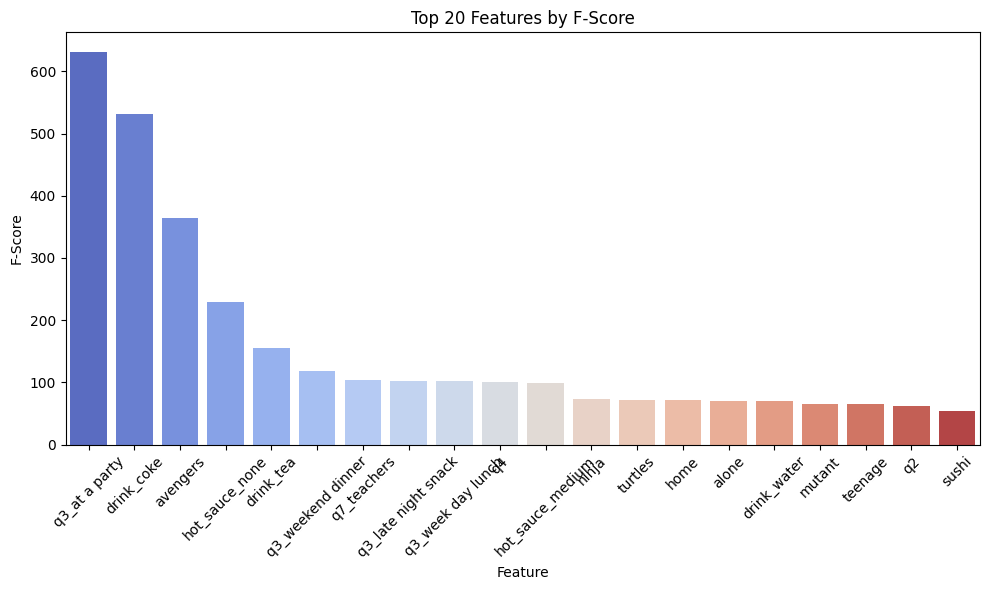

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("cleaned_cleaned_data_combined_modified.csv")

numerical_features = ['q1', 'q2', 'q4']

print("Descriptive Statistics for Numerical Features:")
print(df[numerical_features].describe())

plt.figure(figsize=(15, 5 * len(numerical_features)))
for i, feature in enumerate(numerical_features):

    plt.subplot(len(numerical_features), 2, 2*i+1)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f"Histogram of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

    plt.subplot(len(numerical_features), 2, 2*i+2)
    sns.boxplot(x=df[feature])
    plt.title(f"Boxplot of {feature}")
    plt.xlabel(feature)

plt.tight_layout()
plt.show()

all_columns = df.columns.tolist()

if "q3_late night snack" in all_columns:
    end_index = all_columns.index("q3_late night snack") + 1
else:
    raise ValueError("Column 'q3_late night snack' not found in dataset.")

target_feature = 'label'
non_movie_cat_features = [col for col in all_columns[:end_index] if col not in numerical_features + [target_feature]]

print("Categorical features (non-movie) to be plotted:")
print(non_movie_cat_features)

for feature in non_movie_cat_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=target_feature, hue=feature, palette="viridis")
    plt.title(f"Distribution of {feature} (0s and 1s) by {target_feature}")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.legend(title=feature)
    plt.show()

exclude = set(numerical_features + [target_feature] + non_movie_cat_features)
movie_features = [col for col in all_columns if col not in exclude]

movie_feature_counts = df[movie_features].sum().sort_values(ascending=False)

top20_movie_features = movie_feature_counts.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top20_movie_features.index, y=top20_movie_features.values, palette="magma")
plt.title("Top 20 Movie Features by Count")
plt.xlabel("Movie Feature")
plt.ylabel("Count (Sum of 1's)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df[target_feature])

categorical_encoded = df[non_movie_cat_features + movie_features].apply(pd.to_numeric, errors='coerce')

f_scores, p_values = f_classif(pd.concat([df[numerical_features], categorical_encoded], axis=1), y_encoded)

feature_names = numerical_features + non_movie_cat_features + movie_features
f_score_df = pd.DataFrame({'Feature': feature_names, 'F-Score': f_scores, 'p-value': p_values})
f_score_df = f_score_df.sort_values(by="F-Score", ascending=False)

top20_fscore_features = f_score_df.head(20)

print("\nTop 20 Features with Highest F-Scores:")
print(top20_fscore_features)

plt.figure(figsize=(10, 6))
sns.barplot(x=top20_fscore_features['Feature'], y=top20_fscore_features['F-Score'], palette="coolwarm")
plt.title("Top 20 Features by F-Score")
plt.xlabel("Feature")
plt.ylabel("F-Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


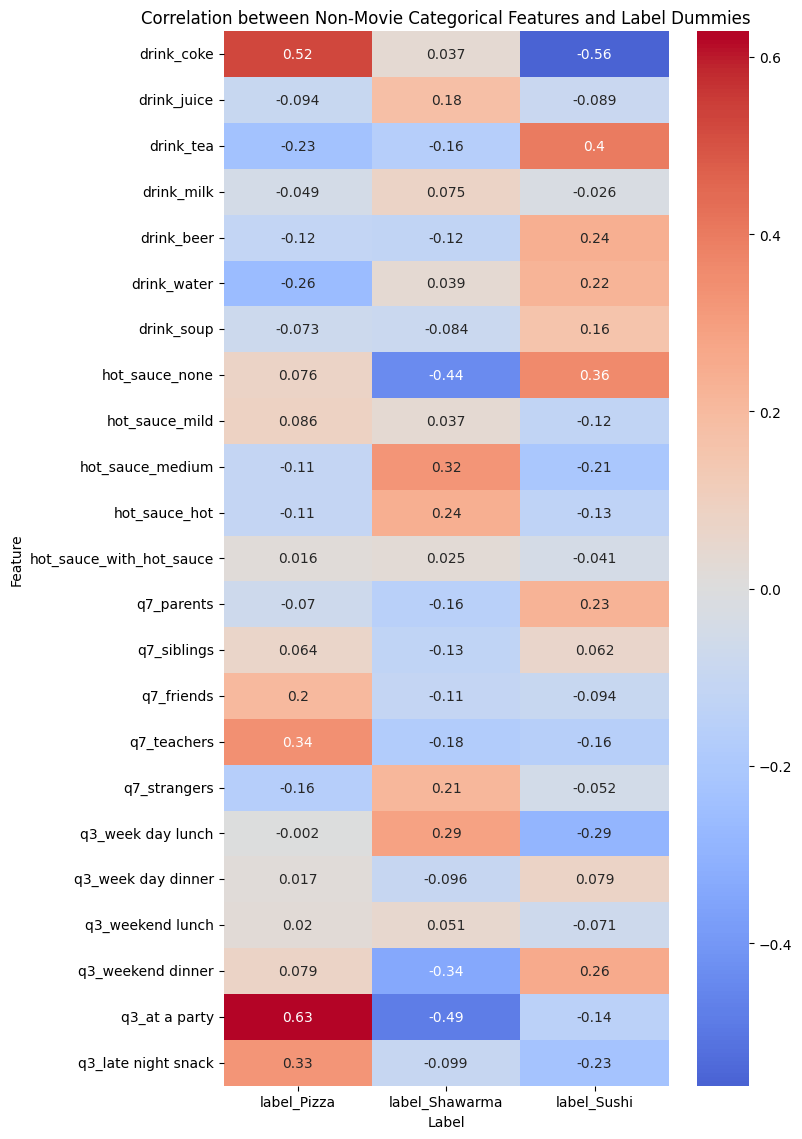

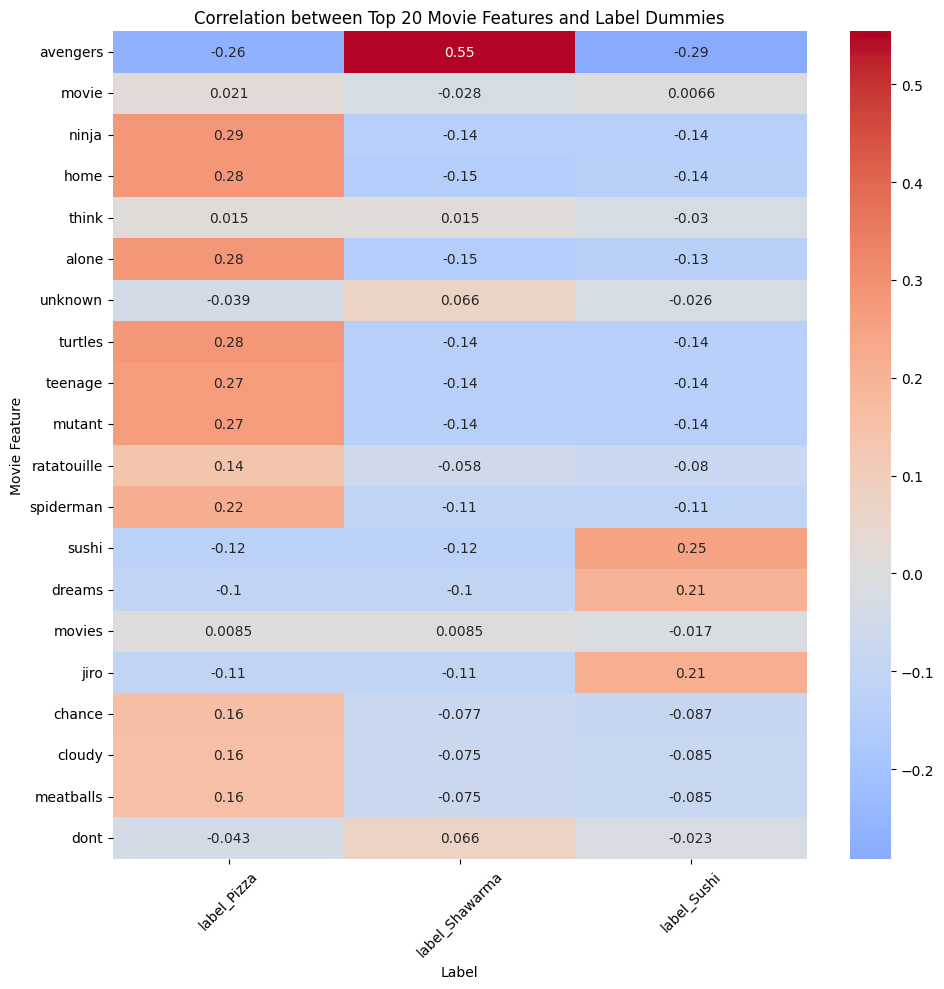

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("cleaned_cleaned_data_combined_modified.csv")

label_dummies = pd.get_dummies(df['label'], prefix='label')
df_with_labels = pd.concat([df, label_dummies], axis=1)

all_columns = df.columns.tolist()
if "q3_late night snack" in all_columns:
    end_index = all_columns.index("q3_late night snack") + 1
else:
    raise ValueError("Column 'q3_late night snack' not found in dataset.")

numerical_features = ['q1', 'q2', 'q4']
target_feature = 'label'
non_movie_cat_features = [col for col in all_columns[:end_index] if col not in numerical_features + [target_feature]]

group1_corr = pd.DataFrame(index=non_movie_cat_features, columns=label_dummies.columns)

for feature in non_movie_cat_features:
    for lbl in label_dummies.columns:
        feature_values = pd.to_numeric(df_with_labels[feature], errors='coerce')
        corr_val = np.corrcoef(feature_values, df_with_labels[lbl])[0, 1]
        group1_corr.loc[feature, lbl] = corr_val

group1_corr = group1_corr.astype(float)

plt.figure(figsize=(8, max(4, 0.5 * len(group1_corr))))
sns.heatmap(group1_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between Non-Movie Categorical Features and Label Dummies")
plt.xlabel("Label")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

exclude = set(numerical_features + [target_feature] + non_movie_cat_features)
movie_features = [col for col in all_columns if col not in exclude]

movie_feature_sums = df[movie_features].sum().sort_values(ascending=False)
top20_movie_features = movie_feature_sums.head(20).index.tolist()

group2_corr = pd.DataFrame(index=top20_movie_features, columns=label_dummies.columns)

for feature in top20_movie_features:
    for lbl in label_dummies.columns:
        feature_values = pd.to_numeric(df_with_labels[feature], errors='coerce')
        corr_val = np.corrcoef(feature_values, df_with_labels[lbl])[0, 1]
        group2_corr.loc[feature, lbl] = corr_val

group2_corr = group2_corr.astype(float)

plt.figure(figsize=(10, max(4, 0.5 * len(group2_corr))))
sns.heatmap(group2_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between Top 20 Movie Features and Label Dummies")
plt.xlabel("Label")
plt.ylabel("Movie Feature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif
from imblearn.over_sampling import SMOTE

df = pd.read_csv("cleaned_cleaned_data_combined_modified.csv")

numerical_features = ['q1', 'q2', 'q4']
target_feature = 'label'

all_columns = df.columns.tolist()
end_index = all_columns.index("q3_late night snack") + 1
non_movie_cat_features = [col for col in all_columns[:end_index] if col not in numerical_features + [target_feature]]

exclude = set(numerical_features + [target_feature] + non_movie_cat_features)
movie_features = [col for col in all_columns if col not in exclude]

df[non_movie_cat_features] = df[non_movie_cat_features].apply(lambda x: pd.factorize(x)[0])

movie_feature_counts = df[movie_features].sum()
selected_movies = movie_feature_counts[movie_feature_counts > 5].index.tolist()
df = df[numerical_features + non_movie_cat_features + selected_movies + [target_feature]]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df[target_feature])

f_scores, _ = f_classif(df.drop(columns=[target_feature]), y_encoded)
feature_names = df.drop(columns=[target_feature]).columns

f_score_df = pd.DataFrame({'Feature': feature_names, 'F-Score': f_scores})
f_score_df = f_score_df.sort_values(by="F-Score", ascending=False).head(20)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(df.drop(columns=[target_feature]), y_encoded)
df_balanced = pd.DataFrame(X_resampled, columns=df.drop(columns=[target_feature]).columns)
df_balanced[target_feature] = y_resampled

df_balanced.to_csv("cleaned_data_rf_friendly.csv", index=False)

print("Data Cleaning Summary (RF-Friendly):")
print(f"Selected Movie Features after Filtering: {len(selected_movies)}")
print("Top 20 Features by F-Score:\n", f_score_df)


Data Cleaning Summary (RF-Friendly):
Selected Movie Features after Filtering: 121
Top 20 Features by F-Score:
                  Feature     F-Score
24         q3_at a party  631.084759
3             drink_coke  531.841669
31              avengers  364.017078
10        hot_sauce_none  228.989277
5              drink_tea  155.556092
23     q3_weekend dinner  119.159693
18           q7_teachers  104.669077
25   q3_late night snack  102.937388
20     q3_week day lunch  102.125866
2                     q4  100.549536
12      hot_sauce_medium   98.788209
108                ninja   72.789559
138              turtles   72.330579
71                  home   71.561962
28                 alone   70.286774
8            drink_water   69.482315
131              teenage   65.997955
103               mutant   65.997955
1                     q2   62.470686
130                sushi   53.713427


<ipython-input-4-2df806944bd0>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_balanced[target_feature] = y_resampled
